# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end.

[See the ESN implementation](https://github.com/cknd/pyESN).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN


## Task

The network will learn to generate a wave signal whose frequency is determined by some slowly changing control input.

#### 1) Generate some sample data:


In [2]:
def signal_to_derivative(signal, max_order=2):
    X = np.array(signal)
    Y = np.zeros((max_order+1, *X.shape))
    Y[0] = X
    for order in np.arange(1, max_order+1):
        Y[order, :-order] = Y[order-1, order:] - Y[order-1, :-order]
    return Y.T

In [3]:
rng = np.random.RandomState(42)
def updown_generator(N,min_period,max_period,n_changepoints):
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    updown_control = np.ones((N,2))
    up = True
    for (t0,t1) in const_intervals:
        if t0 != t1:
            if up:
                updown_control[t0:t1,0] = np.linspace(0,1,t1-t0)
            else:
                updown_control[t0:t1,0] = np.linspace(1,0,t1-t0)
            up = not up
    return updown_control
    


In [4]:

N = 15000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
x = updown_generator(N,min_period,max_period,n_changepoints)

max_order = 2
y = signal_to_derivative(x[:, 0], max_order)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = x[:traintest_cutoff], y[:traintest_cutoff]
test_ctrl, test_output  = x[traintest_cutoff:], y[traintest_cutoff:]

#### 2) Instantiate, train & test the network
Parameters are mostly the same as in Herbert Jaeger's original Matlab code. 

In [5]:
esn = ESN(n_inputs = 2,
          n_outputs = max_order+1,
          n_reservoir = 200,
          spectral_radius = 0.2,
          sparsity = 0.3,
          noise = 0.001,
          input_shift = [-.5,-.5],
          input_scaling = [2, 2],
          teacher_scaling = .2,
          teacher_shift = 0,
          out_activation = np.tanh,
          inverse_out_activation = np.arctanh,
          random_state = rng,
          silent = False)

pred_train = esn.fit(train_ctrl,train_output)

print("test error:")
pred_test = esn.predict(test_ctrl)
print(np.sqrt(np.mean((pred_test - test_output)**2)))

harvesting states...
fitting...
training error:
0.0045305845597066316
test error:
0.00593386083333798


#### 3) Plots
First, a look at the control signal, the target signal and the output of the model both during training and during testing.

Text(0.5, 1.0, 'training (excerpt)')

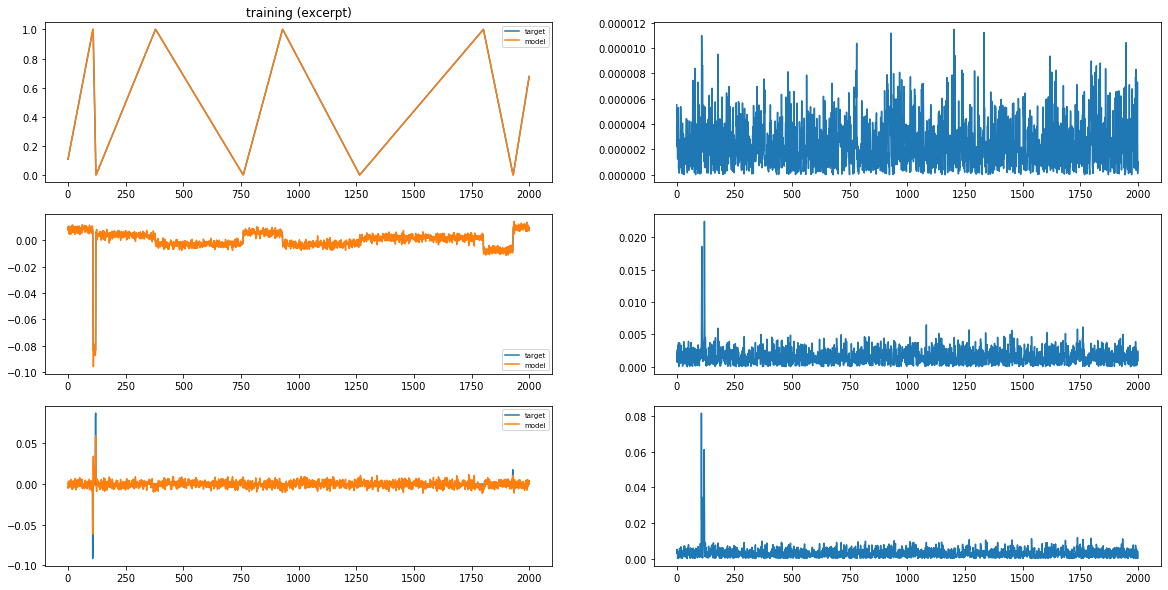

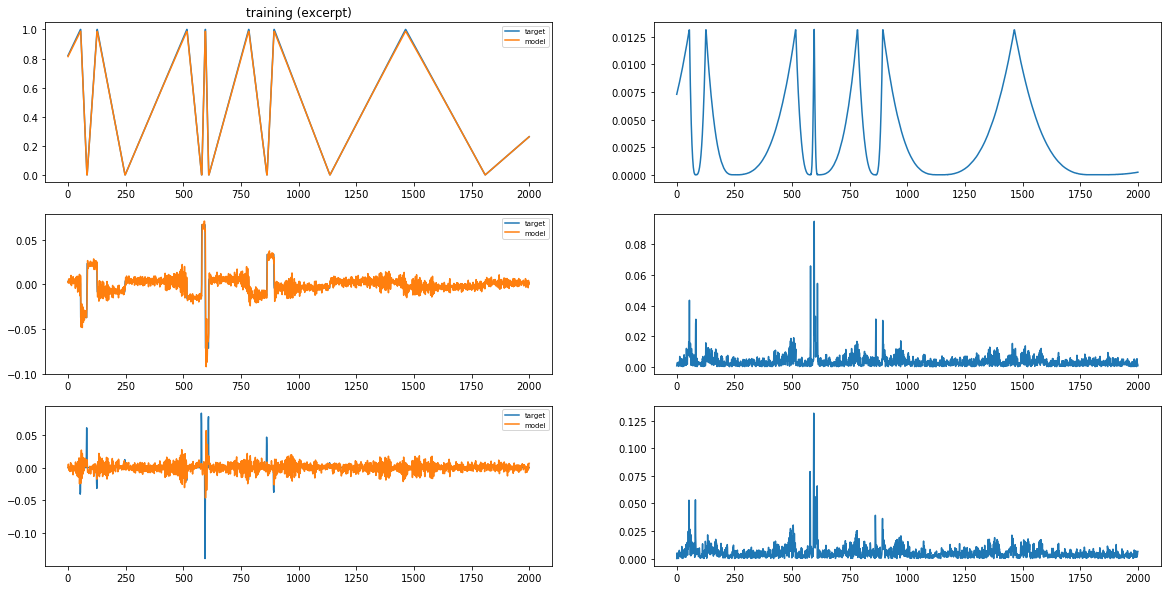

In [6]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
fig, axes = plt.subplots(3,2, figsize=(20,10))
for axrow, y, yhat in zip(axes, train_output.T, pred_train.T):
    axrow[0].plot(y[window_tr],label='target')
    axrow[0].plot(yhat[window_tr],label='model')
    axrow[0].legend(fontsize='x-small')
    axrow[1].plot(abs(y[window_tr]-yhat[window_tr]))
axes[0,0].set_title('training (excerpt)')

window_test = range(2000)
fig, axes = plt.subplots(3,2, figsize=(20,10))
for axrow, y, yhat in zip(axes, test_output.T, pred_test.T):
    axrow[0].plot(y[window_test],label='target')
    axrow[0].plot(yhat[window_test],label='model')
    axrow[0].legend(fontsize='x-small')
    axrow[1].plot(abs(y[window_test]-yhat[window_test]))
axes[0,0].set_title('training (excerpt)')
